In [1]:
!poetry add pymilvus llama_index ftfy regex tqdm 
!poetry add transformers
!poetry add llama-index-vector-stores-milvus llama-index-llms-ollama llama-index-embeddings-huggingface
!poetry add git+https://github.com/openai/CLIP.git
!poetry add torch torchvision
!poetry add matplotlib scikit-image
!poetry add wikipedia

The following packages are already present in the pyproject.toml and will be skipped:

  - pymilvus
  - llama_index
  - ftfy
  - regex
  - tqdm

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - transformers

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - llama-index-vector-stores-milvus
  - llama-index-llms-ollama
  - llama-index-embeddings-huggingface

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to t

In [3]:
from pathlib import Path
import requests

wiki_titles = ["Helsinki", "iPhone", "The Sopranos"]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [2]:
from pymilvus import MilvusClient

from llama_index.core import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.llms.ollama import Ollama

text_client = MilvusClient()
text_documents = SimpleDirectoryReader("./data_wiki").load_data()

service_context = ServiceContext.from_defaults(
    llm=Ollama(model="llama3", request_timeout=120.0, temperature=0.1),
    embed_model="local:BAAI/bge-base-en-v1.5",
)

text_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_text", dim=768, overwrite=True
)

storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

wiki_text_index = VectorStoreIndex.from_documents(
    text_documents, storage_context=storage_context, service_context=service_context
)

text_query_engine = wiki_text_index.as_query_engine()

/Users/stephen/Library/Caches/pypoetry/virtualenvs/multimodal-milvus-clip-SwowcNo4-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/kv/3dw9p_ts4b114chqt9m027pc0000gn/T/ipykernel_58008/3242720480.py:14: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(
/Users/stephen/Library/Caches/pypoetry/virtualenvs/multimodal-milvus-clip-SwowcNo4-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings

In [5]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")

In [6]:
import wikipedia
import urllib.request

image_path = Path("images_wiki")
image_uuid = 0

image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = ["Helsinki", "iPhone", "The Sopranos"]

if not image_path.exists():
    Path.mkdir(image_path)

# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")
                images_per_wiki += 1
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        continue

Helsinki
iPhone
The Sopranos


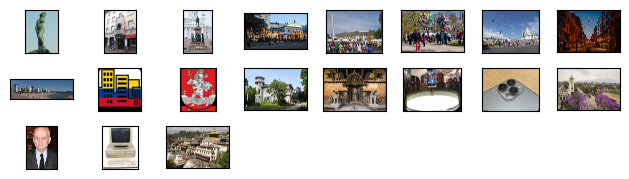

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)

img_emb_dict = {}
with torch.no_grad():
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )
            image_features = model.encode_image(image)
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [9]:
from llama_index.core.schema import ImageDocument

img_documents = []
for image_filename in image_metadata_dict:
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]

        newImgDoc = ImageDocument(text=filename, metadata={"filepath": filepath})

        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

image_vector_store = MilvusVectorStore(
    client=text_client, collection_name="wikipedia_img", dim=512, overwrite=True
)

storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

image_index = VectorStoreIndex.from_documents(
    img_documents, storage_context=storage_context
)

In [10]:
from llama_index.core.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """take a text query as input and return the most similar image from the vector store"""

    text = clip.tokenize(query).to(device)

    query_embedding = model.encode_text(text).tolist()[0]

    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1,  # returns 1 image
        mode="default",
    )

    image_retrieval_results = image_vector_store.query(image_vector_store_query)
    return image_retrieval_results

In [11]:
def plot_image_retrieve_results(image_retrieval_results):
    """take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [12]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

Text retrieval results: 
The original iPhone has been described as "revolutionary" and "breakthrough handheld computer". It is now Apple's bestselling product, credited with helping to make Apple one of the world's most valuable publicly traded companies by 2011. Newer iterations have also received praise and awards. The iPhone was the first mobile phone to use multi-touch technology and has since gained larger screen sizes, video- recording, waterproofing, and many accessibility features.


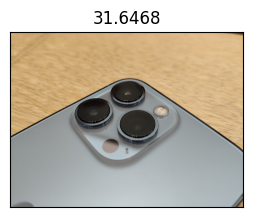

In [13]:
# https://en.wikipedia.org/wiki/iPhone
query1 = "Can you tell me more about the iPhone?"
image_query(query1)

text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Some popular tourist attractions in Helsinki include Suomenlinna (Sveaborg), a fortress island with a rich history, and Korkeasaari Zoo, located on one of Helsinki's main islands. Additionally, the city has many nature reserves, including Vanhankaupunginselkä, which is the largest nature reserve in Helsinki.


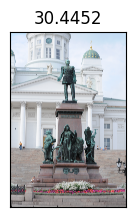

In [14]:
# https://en.wikipedia.org/wiki/Helsinki
query2 = "What are some of the popular tourist attraction in Helsinki?"
image_query(query2)

text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))